# Papagaio - MIDI generation using Bi-Directional LSTM

## Setup

##### Install, import and configure dependencies

In [127]:
!pip install -q music21
!pip install -q fastprogress
# !pip install -q midi2audio
# !pip install -q fluidsynth

In [128]:
# Basic libraries
import os
import random
import time
import pickle
import glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Preprocessing data libraries
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

# Model libraries
import torch
import torch.nn as nn
import torch.optim as optim

# Data visualization
from torch.utils.tensorboard import SummaryWriter

# Utils
import music21
from fastprogress.fastprogress import master_bar, progress_bar

# Playing files
# from midi2audio import FluidSynth
# import midi2audio
import pygame

# Codification modules
from ems import serialisation, deserialisation

# Environment setup
%matplotlib inline
# music21.configure.run()
import notebook

##### Set device

In [129]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

# DATASET

##### Separate Stackframe data from Info data 

In [130]:

# TODO: receive a input int for the amount of info data (currently 4).
#       this way testing will be easier.

def getPerformance(data, first_frame, last_frame, to_float=True):
    stackframe = data.iloc[first_frame:last_frame, 4:]
    stackframe = stackframe.to_numpy()

    if to_float:
        stackframe.astype(float)
        stackframe = stackframe + 0.0

    return stackframe

def getInfo(data, first_frame, last_frame):
    infos = data.iloc[first_frame:last_frame, 0:4]
    return infos

##### Merge Stackframe and Info to match the codification

In [131]:
def mergeData(infos, stackframe, instrument, midi_offset):

    # (A, B, C)
    #
    # A -> number of measures (bars)
    # B -> number of frames (resolution)
    # C -> number of notes (keyboard size)

    n_measures = stackframe.shape[0]
    resolution = stackframe.shape[1]
    keyboard_size = stackframe.shape[2]

    # Generate note names and use as column
    sf_columns = [serialisation.key_index2note(i, midi_offset).nameWithOctave for i in range(keyboard_size)]
    
    # Initialize blank df with notes column
    measures = pd.DataFrame([], columns=sf_columns)
    measures.index.name = 'inst'
    
    # 
    for i in range(n_measures):
        indexes = pd.Series([instrument for i in range(resolution)])
        decoded_measure = pd.DataFrame(stackframe[i], columns=sf_columns).set_index(pd.Index(indexes)) 
        measures = measures.append(decoded_measure) 

    print(f'Info shape {infos.shape} | measures shape {measures.shape}')
    
    output = pd.concat([infos, measures], axis=1)

    print(f'Result shape {output.shape}')

    return output

# Reshape so that we have all frames in one dimension
# generated_sf = generated_sf.reshape(-1, generated_sf.shape[-1])
# print(f'Reshaped stackframe: \n {generated_sf} \t Shape: {generated_sf.shape}')


##### Read all dataset and isolates the data from a single instrument

In [132]:
def createInstrumentPerformanceDataset(datasetPath, instrument, resolution):
    instrumentPerformanceDataset = []
    interpreted_files = glob.glob(f'{datasetPath}**/**.pkl', recursive=True)
    for int_file in interpreted_files:

        int_file_path = Path(int_file)
        interpreted_file = pd.read_pickle(int_file_path)
        # print(interpreted_file.head())

        interpreted_instrument = interpreted_file[interpreted_file.index==instrument]
        if(interpreted_instrument.empty):
            continue
        # print(interpreted_instrument.head())

        first_frame = 0
        last_frame = len(interpreted_instrument)

        interpreted_performance = getPerformance(interpreted_instrument, first_frame=first_frame, last_frame=last_frame)
        # print(interpreted_performance.head())
        
        instrumentPerformanceDataset.append(np.array(interpreted_performance))
      
    return instrumentPerformanceDataset

##### Split dataset into two blocks, one frame apart at every single index

In [133]:
def preparePerformanceTrainingExamples(dataset, resolution):
    X = []
    y = []
    
    # create two arrays X, y with bars
    for performance in dataset:
        # create the frame blocks shifted in one position
        for i in range(performance.shape[0] - resolution):
            j = i + resolution
            xa = performance[i:j]
            ya = performance[i+1:j+1]
            X.append(xa)
            y.append(ya)
        
    X = np.array(X, dtype='float64')
    y = np.array(y, dtype='float64')
    X = torch.from_numpy(X)
    y = torch.from_numpy(y)
    
    training_ds = TensorDataset(X, y) # (X, y)
    return training_ds

In [134]:
def getPerformanceSample(dataloader):

  n_training_examples = len(dataloader.dataset.tensors[0])

  input = torch.zeros(n_training_examples, SETTINGS.RESOLUTION, SETTINGS.KEYBOARD_SIZE)
  target = torch.zeros(n_training_examples, SETTINGS.RESOLUTION, SETTINGS.KEYBOARD_SIZE)

  for sample, (xb, yb) in enumerate(dataloader): # gets the samples
    input[sample] = xb
    target[sample] = yb
  
  return input, target

# MODEL

##### Define model class with heritage of PyTorch's Module

In [135]:
class BI_LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    super(BI_LSTM, self).__init__()

    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=False, bidirectional=True)
    self.fc1 = nn.Linear(hidden_size*2, hidden_size*2)
    self.fc2 = nn.Linear(hidden_size*2, output_size)
    self.relu = nn.ReLU()
    self.softplus = nn.Softplus(beta=500, threshold=0)
    self.sigmoid = nn.Sigmoid()

    # self.fromInstrument = 
    # self.toInstrument = 

  def forward(self, x, hidden, cell):
    # Passing in the input and hidden state into the model and obtaining outputs
    out, (hidden, cell) = self.lstm(x.unsqueeze(1), (hidden, cell))

    # Reshaping the outputs such that it can be fit into the fully connected layer
    out = out.contiguous().view(-1, self.hidden_size*2)

    out = self.fc2(out)
    out = self.sigmoid(out)
    
    return out, (hidden, cell)

  def init_hidden(self, batch_size):
    # This method generates the first hidden state of zeros which we'll use in the forward pass
    # We'll send the tensor holding the hidden state to the device we specified earlier as well
    hidden = torch.zeros(self.num_layers*2, batch_size, self.hidden_size).to(device)
    cell = torch.zeros(self.num_layers*2, batch_size, self.hidden_size).to(device)
    
    return hidden, cell

In [136]:
def plot_loss_update(epoch, epochs, mb, train_loss):
    """ dynamically print the loss plot during the training/validation loop.
        expects epoch to start from 1.
    """
    x = range(1, epoch+1)
    y = train_loss
    graphs = [[x,train_loss]]
    x_margin = 0.2
    y_margin = 0.05
    x_bounds = [1-x_margin, epochs+x_margin]
    y_bounds = [np.min(y)-y_margin, np.max(y)+y_margin]

    mb.update_graph(graphs, x_bounds, y_bounds)

##### Training loop

In [137]:
def train(model, optimizer, loss_fn, dataloader, save_as, batch_size=1, num_epochs=50):
    writer = SummaryWriter()

    print("[Train Starting]")

    s_time = time.time()

    mb = master_bar(range(1, num_epochs+1))
    mb.names = ['Loss', 'FrameBlock']
    train_loss = []


    for epoch_index in mb:
        count = 0
        training_loss = 0.0

        n_training_examples = len(dataloader.dataset.tensors[0])

        input, target = getPerformanceSample(dataloader)
        input = input.to(device)
        target = target.to(device)
        
        # Initialize hidden and cells
        hidden, cell = model.init_hidden(batch_size)

        for training_example_index in progress_bar(range(n_training_examples), parent=mb):

            # Generate predictions
            frameblock = input[training_example_index,:]
            output, (hidden, cell) = model(frameblock, hidden, cell)
            

            # Compute the loss and backpropag
            loss_step = loss_fn(output, target[training_example_index, :])

            hidden = hidden.detach()
            cell = cell.detach()

            count += 1

            loss_step.backward() # Does backpropagation and calculates gradients
            optimizer.step() # Updates the weights accordingly
            optimizer.zero_grad() # Clears existing gradients from previous frame

            training_loss += loss_step.item()

            mb.child.comment = f'[Loss {training_loss:.8f}]'

        training_loss /= len(dataloader.dataset)
        writer.add_scalar("Loss/train", training_loss, epoch_index)

        train_loss.append(training_loss)
        mb.main_bar.comment = f'[Epoch {epoch_index} | Loss {training_loss:.8f}]'
        plot_loss_update(epoch_index, num_epochs, mb, train_loss)

        if (epoch_index % 5) == 0:
            torch.save(model, f'{save_as}[{epoch_index}].pt')

    writer.flush()
    writer.close()

    print(f'[Finished training with Loss {training_loss:.8f} (took {time.time() - s_time} seconds)]')

##### Given the model and some context data, generate a certain amount of measures (default: 1)

In [138]:
# TODO: Be able to especify the number of measures to predict!

@torch.no_grad()
def generateMeasures(model, context, resolution, amount=1, temperature=0.5, batch_size=1):
    hidden, cell = model.init_hidden(batch_size)

    if isinstance(context, torch.Tensor):
      # send to gpu
      context_performance_block = context.cuda()
      # cast to float
      context_performance_block = context_performance_block.float()
    else:
      context_performance_block = torch.from_numpy(context.astype(float)).float().to(device)

    # amount of frameblocks in the context input
    n_context_performance_block = len(context_performance_block) - resolution

    # getting context iterating over
    # N-1 of the frameblocks

    for i in range(n_context_performance_block):
        context_performance = context_performance_block[i:i + resolution]

        # we dont care about the output here.
        # we are just feeding the model with the
        # context we received as input
        _, (hidden, cell) = model(context_performance,
                                  hidden, cell)

    # we must get the output from the last context fb
    last_context_performance = context_performance_block[n_context_performance_block:]

    output_measures = []
    for _ in range(amount):
      
      out, (hidden, cell) = model(last_context_performance, hidden, cell)
      
      # generate the other remaining frames
      for i in range(resolution- 1):
        out = torch.where(out >= (1-temperature), 1, 0).float()
        out, (hidden, cell) = model(out, hidden, cell)

        # update last frame block
        last_context_performance = out


      out = np.where(out.cpu() >= (1-temperature), True, False)
      output_measures.append(out)

    # print(out, out.shape)
    return np.array(output_measures, dtype=bool)

##### Instanciate with desired parameters

In [139]:
SETTINGS = pd.Series(
  {
    'RESOLUTION': 36, # Frame per measure amount
    'KEYBOARD_SIZE': 88, # Amount of keys in the Model's Keyboard
    'KEYBOARD_OFFSET': 20 # MIDI index for the first Model's Keyboard key
  }
)


NUM_LAYERS = 4

# Instantiate the model with hyperparameters
# We'll also set the model to the device that we defined earlier
model = BI_LSTM(input_size=SETTINGS.KEYBOARD_SIZE,
                output_size=SETTINGS.KEYBOARD_SIZE,
                hidden_size=SETTINGS.RESOLUTION,
                num_layers=NUM_LAYERS).to(device)

# TRAIN MODEL

##### Set training options

In [140]:
lr = 3e-4 # Learning Rate
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss() # Binary Cross Entropy

MODELS_PATH = '../models/'
MODEL_NAME = 'BI_LSTM'

N_EPOCHS = 50 # Number of times that the model will go trough all the 

##### Let's create a dataset for a given instrument, in this case I'll choose piano

In [141]:
datasetName = 'original'
datasetPath = f'../papagaio_dataset/interpreted/{datasetName}/' # dataset outside the repo

modelType = 'prediction'
modelPath  = f'../models/{modelType}/{datasetName}/'
os.makedirs(modelPath, exist_ok=True)

INSTRUMENT = 'Electric guitar'

instrumentPerformanceDataset = createInstrumentPerformanceDataset(datasetPath, INSTRUMENT, SETTINGS.RESOLUTION)
print(f'Dataset {datasetName}, Instrument {INSTRUMENT}, Instrument Performance Dataset size {len(instrumentPerformanceDataset)}')

Dataset original, Instrument Electric guitar, Instrument Performance Dataset size 75


##### Prepare training Dataset and Dataloader

In [142]:
training_ds = preparePerformanceTrainingExamples(instrumentPerformanceDataset, SETTINGS.RESOLUTION)
training_dl = DataLoader(training_ds, batch_size=1, shuffle=False)

print(f'Amount of training examples:\t{len(training_dl.dataset.tensors[0])}')

Amount of training examples:	161170


### Run train

In [143]:
model = torch.load("models/BI_LSTM_[Electric guitar][5].pt")
# SAVE_AS = f'{modelPath}{MODEL_NAME}_[{INSTRUMENT}]' # Name of the output LSTM data

#!jupyter nbextension enable --py widgetsnbextension
# train(model, optimizer, loss_fn, training_dl, SAVE_AS, num_epochs=N_EPOCHS)

# GENERATE
##### Prepare context data representation

In [144]:
# Read context file
CONTEXT = pd.read_pickle(datasetPath + 'Foo Fighters/The Pretender.pkl')

# Filter by instrument
CONTEXT = CONTEXT[CONTEXT.index==INSTRUMENT]

# If the file does not contain the instrument
if len(CONTEXT) == 0:
    raise ValueError(f'Oops, it seems that the selected context file does not contain this instrument ({INSTRUMENT}).')

print(f'{INSTRUMENT} context data shape {CONTEXT.shape}')
print(f'{INSTRUMENT} context measures {int(CONTEXT.shape[0] / SETTINGS.RESOLUTION)}')

Electric guitar context data shape (315, 92)
Electric guitar context measures 8


##### Set generation parameters

In [145]:
CONTEXT_FIRST_MEASURE = 1
CONTEXT_AMOUNT = 4 # Amount of measures of context
GENERATE_AMOUNT = 4 # Amount of measures to generate
TEMPERATURE = 0.5 # Predicted probability must be >= 80% to note be played

# INFO_SIZE = 4

first_context_frame = (CONTEXT_FIRST_MEASURE-1)*SETTINGS.RESOLUTION
last_context_frame = first_context_frame + SETTINGS.RESOLUTION*CONTEXT_AMOUNT

first_generated_frame = last_context_frame
last_generated_frame = first_generated_frame + SETTINGS.RESOLUTION*GENERATE_AMOUNT

context_info = getInfo(CONTEXT, first_context_frame, last_context_frame)
context_performance = getPerformance(CONTEXT, first_context_frame, last_context_frame, to_float=True)

generated_info = getInfo(CONTEXT, first_generated_frame, last_generated_frame)

print(f'CONTEXT_INFO: \n {context_info} \n\n')
print(f'CONTEXT_PERFOMANCE: \n {context_performance} \t Shape: {context_performance.shape}')

print(f'GENERATED_INFO: \n {generated_info}')

CONTEXT_INFO: 
                 MIDI_CODE KS   TS TEMPO
INSTRUMENT                             
Electric guitar        27  C  4/4  90.0
Electric guitar        27  C  4/4  90.0
Electric guitar        27  C  4/4  90.0
Electric guitar        27  C  4/4  90.0
Electric guitar        27  C  4/4  90.0
...                   ... ..  ...   ...
Electric guitar        27  C  4/4  90.0
Electric guitar        27  C  4/4  90.0
Electric guitar        27  C  4/4  90.0
Electric guitar        27  C  4/4  90.0
Electric guitar        27  C  4/4  90.0

[144 rows x 4 columns] 


CONTEXT_PERFOMANCE: 
 [[0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 ...
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]] 	 Shape: (144, 88)
GENERATED_INFO: 
                 MIDI_CODE KS   TS TEMPO
INSTRUMENT                             
Electric guitar        27  C  4/4  90.0
Electric guitar        27  C  4/4  90.0
Electric guitar        27 

##### Let's see the context we'll feed the model

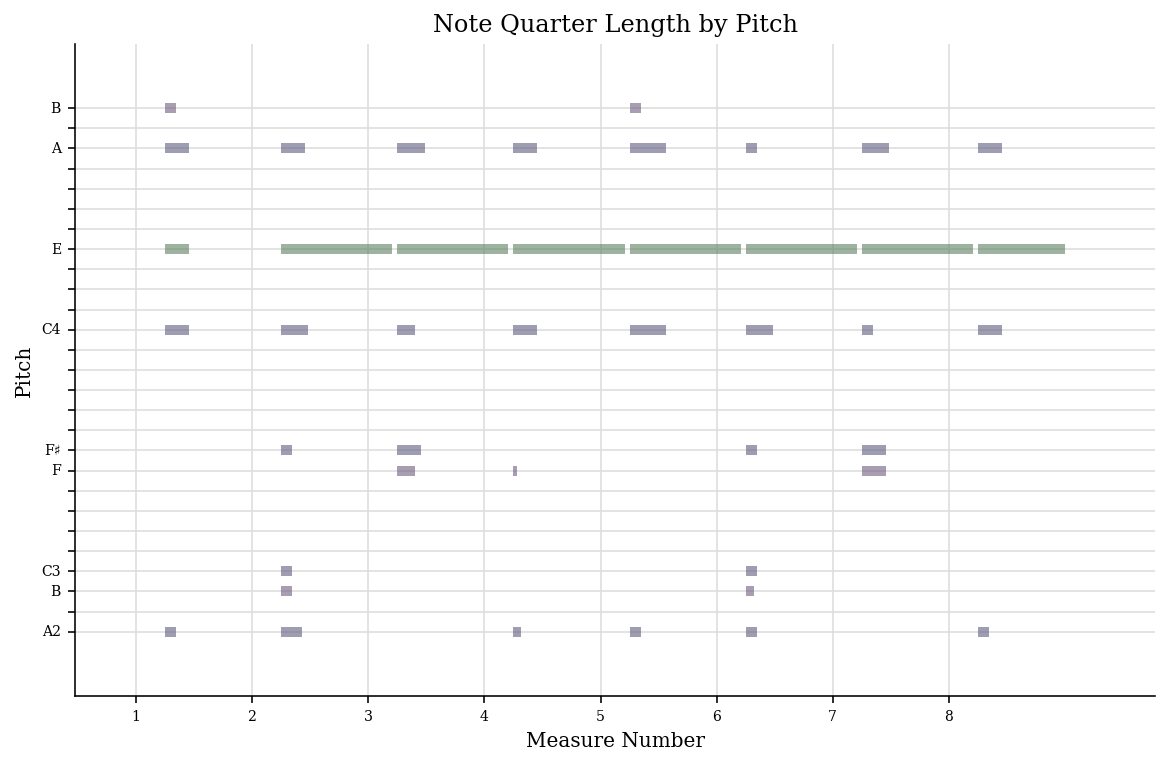

In [146]:
deserialisation.file(CONTEXT, SETTINGS).plot()

##### Generate measures stackframes

In [157]:
start_timer = time.time()
generated_performance = generateMeasures(   model,
                                            context_performance,
                                            SETTINGS.RESOLUTION,
                                            amount=GENERATE_AMOUNT,
                                            temperature=TEMPERATURE
                                            )
end_timer = time.time()
print(f'GENERATED PERFORMANCE: \n {generated_performance} \t Shape: {generated_performance.shape}')
print(f'Generated {generated_performance.shape[0]} measures in {end_timer - start_timer} seconds')

GENERATED PERFORMANCE: 
 [[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False 

##### Merge Info and StackFrame to get the complete, decodable representation

In [167]:
# Merge StackFrame and Info blocks
generated_representation = mergeData(generated_info, generated_performance, INSTRUMENT, SETTINGS.KEYBOARD_OFFSET)
# Concat the context and the generated part
generated_full = pd.concat([CONTEXT, generated_representation])

print(f'Generated representation: \n {generated_representation.to_string()}')

Info shape (144, 4) | measures shape (144, 88)
Result shape (144, 92)
Generated representation: 
                 MIDI_CODE KS   TS TEMPO    G#0     A0    B-0     B0     C1    C#1     D1    E-1     E1     F1    F#1     G1    G#1     A1    B-1     B1     C2    C#2     D2    E-2     E2     F2    F#2     G2    G#2     A2    B-2     B2     C3    C#3     D3    E-3     E3     F3    F#3     G3    G#3     A3    B-3     B3     C4    C#4     D4    E-4    E4     F4    F#4     G4    G#4     A4    B-4     B4     C5    C#5     D5    E-5     E5     F5    F#5     G5    G#5     A5    B-5     B5     C6    C#6     D6    E-6     E6     F6    F#6     G6    G#6     A6    B-6     B6     C7    C#7     D7    E-7     E7     F7    F#7     G7    G#7     A7    B-7     B7
Electric guitar        27  C  4/4  90.0  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  Fal

##### Send generated representation to the decoder module and plot result

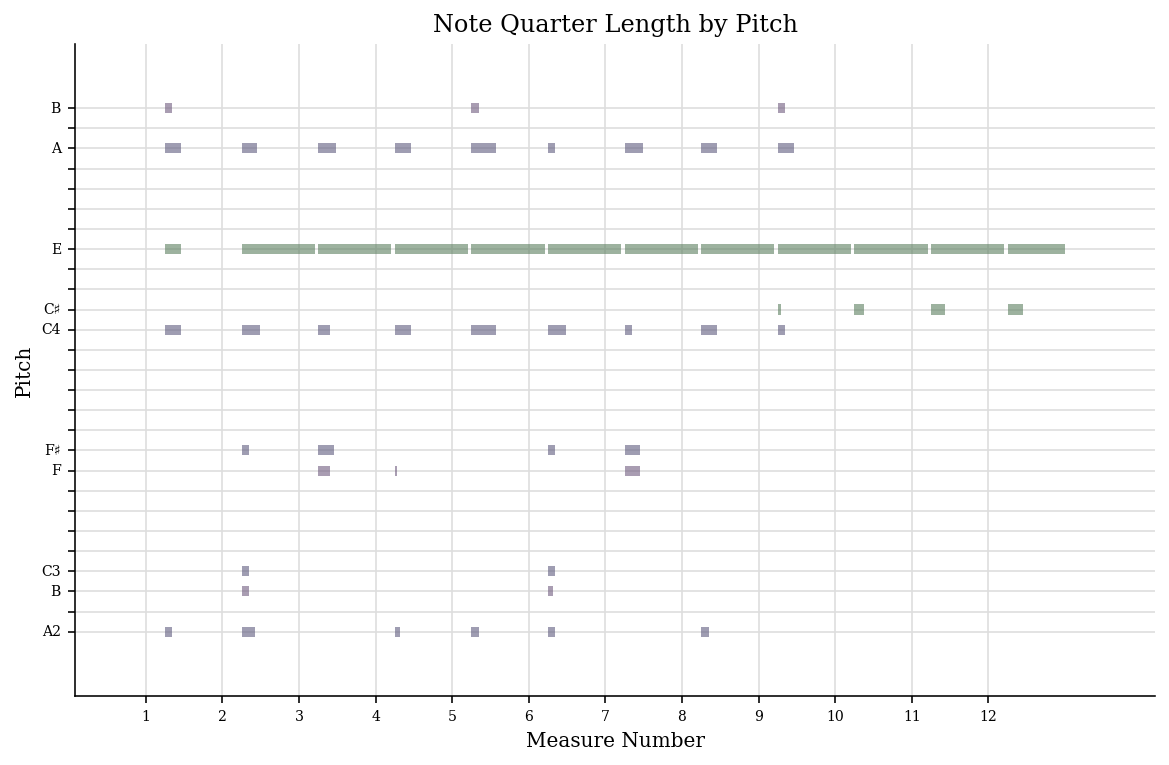

In [168]:
OUTPUT_PATH = f'models/results/The Pretender_test.mid'

# Send representation to decoder
generated = deserialisation.file(generated_full, SETTINGS, save_as=OUTPUT_PATH)

generated.plot()

# HEARING GENERATED
##### Now we can play the generated midi file

In [169]:
# synth = midi2audio.FluidSynth()
# synth.midi_to_audio(OUTPUT_PATH+'.mid', OUTPUT_PATH+'.mid'+'.wav')
# synth.play_midi()

# https://stackoverflow.com/questions/6030087/play-midi-files-in-python
def play_music(midi_filename):
  '''Stream music_file in a blocking manner'''
  clock = pygame.time.Clock()
  pygame.mixer.music.load(midi_filename)
  pygame.mixer.music.play()
  while pygame.mixer.music.get_busy():
    clock.tick(30) # check if playback has finished

midi_filename = OUTPUT_PATH

# mixer config
freq = 44100  # audio CD quality
bitsize = -16   # unsigned 16 bit
channels = 2  # 1 is mono, 2 is stereo
buffer = 1024   # number of samples
pygame.mixer.init(freq, bitsize, channels, buffer)

# optional volume 0 to 1.0
pygame.mixer.music.set_volume(0.8)

play_music(midi_filename)